GitHub: https://github.com/MYUSER/MYPROJECT/


Welcome to your assignment this week! 

To better understand the adverse use of AI, in this assignment, we will look at a Natural Language Processing use case.


Natural Language Pocessing (NLP) is a branch of Artificial Intelligence (AI) that helps computers to understand, to interpret and to manipulate natural (i.e. human) language.
Imagine NLP-powered machines as black boxes that are capable of understanding and evaluating the context of the input documents (i.e. collection of words), outputting meaningful results that depend on the task the machine is designed for.


![](imgs/1_3zMvUnPzYZF9CSHdj6hT5A.png)

<caption><center> Documents are fed into magic NLP model capable to get, for instance, the sentiment of the original content</center></caption>


In this notebook, you will implement a model that uses an LSTM to generate fake tweets and comments. You will also be able to try it to generate your own fake text. 

**You will learn to:**
- Apply an LSTM to generate fake comments.
- Generate your own fake text with deep learning.

Please run the following cell to load all the packages required in this assignment. This may take a few minutes. 


In [1]:
#!pip install numpy
#!pip install keras
#!pip install tensorflow

Run the following cell to load the packages you will need.

In [2]:
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

# Build the model

Let's define a tokenizer and read the data from disk.

In [3]:
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
data = open('covid19_fake.txt').read().replace(".", " . ").replace(",", " , ").replace("?", " ? ").replace("!", " ! ")

Now, let's splits the data into tweets  where each line of the input file is a fake tweets.

We also extract the vocabulary of the data.

In [4]:
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

You've loaded:
- `corpus`: an array where each entry is a fake post.
- `tokenizer`: which is the object that we will use to vectorize our dataset. This object also contains our word index.
- `total_words`: is the total number of words in the vacabulary.


In [5]:
print("Example of fake tweets: ",corpus[:2])
print("Size of the vocabulary = ", total_words)
index = [(k, v) for k, v in tokenizer.word_index.items()]
print("Example of our word index = ", index[0:10])

Example of fake tweets:  ['there is already a vaccine to treat covid19 . ', 'cleaning hands do not help to prevent covid19 . ']
Size of the vocabulary =  1257
Example of our word index =  [('.', 1), ('the', 2), ('covid19', 3), ('in', 4), ('to', 5), ('a', 6), ('of', 7), (',', 8), ('coronavirus', 9), ('and', 10)]


The next step aims to generate the training set of n_grams sequences.

In [6]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

You've create:
- `input_sequences`: which is a list of n_grams sequences.

In [7]:
sample = 20
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
for i in input_sequences[sample]:
    print(reverse_word_map[i], end=' ')
                        

The entry  20  in 'input_sequences' is: 
[2, 3, 12, 187, 34, 188]
 and it corresponds to:
the covid19 is same as sars 

Next, we padd our training set to the max length in order to be able to make a batch processing.

In [8]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Run the following to see the containt of the padded 'input_sequences' object.

In [9]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
print("[", end=' ')
for i in input_sequences[sample]:
    if i in reverse_word_map:
        print(reverse_word_map[i], end=' ')
    else:
        print("__", end=' ')
print("]")
                

The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
 and it corresponds to:
[ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ the covid19 is same as sars ]


Given a sentence like **"the covid19 is same as "**, we want to design a model that can predict the next word -- in the case the word **"sars"**.

Therefore, the next code prepares our input and output to our model consequently.

In [10]:
input_to_model, label = input_sequences[:,:-1],input_sequences[:,-1]


In [11]:
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(", it corresponds to the following input to our model:")
print(input_to_model[sample])
print(" and the following output: ", label[sample])


The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
, it corresponds to the following input to our model:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34]
 and the following output:  188


Finally, we convert our label to categorical labels for being processed by our model.

In [12]:
label = ku.to_categorical(label, num_classes=total_words)

Here is the architecture of the model we will use:

![](imgs/text_generation.png)



 
**Task 1**: Implement `deep_fake_comment_model()`. You will need to carry out 5 steps:

1. Create a sequencial model using the `Sequential` class
2. Add an embedding layer to the model using the `Embedding` class of size 128
3. Add an LSTM layer to the model using the `LSTM` class of size 128
4. Add a Dense layer to the model using the `Dense` class with a `softmax` activation
5. Set a `categorical_crossentropy` loss function to the model and optimize `accuracy`.


In [13]:
#TASK 1
# deep_fake_comment_model
size = 128
def deep_fake_comment_model():
    ### START CODE HERE ### 
    model = Sequential()
    model.add(Embedding(1257, size, input_length=60))
    model.add(LSTM(size))
    model.add(Dropout(0.2))
    model.add(Dense(1257, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    ### END CODE HERE ### 
    
#Print details of the model.
model = deep_fake_comment_model()


Now, let's start our training.

In [14]:
history = model.fit(input_to_model, label, epochs=200, batch_size=32, verbose=1)

Epoch 1/200
126/126 [==============================] - 1s 10ms/step - loss: 6.3508 - accuracy: 0.0695
Epoch 2/200
126/126 [==============================] - 1s 9ms/step - loss: 5.8868 - accuracy: 0.0759
Epoch 3/200
126/126 [==============================] - 1s 8ms/step - loss: 5.7512 - accuracy: 0.0811
Epoch 4/200
126/126 [==============================] - 1s 8ms/step - loss: 5.6440 - accuracy: 0.1032
Epoch 5/200
126/126 [==============================] - 1s 8ms/step - loss: 5.4931 - accuracy: 0.1241
Epoch 6/200
126/126 [==============================] - 1s 8ms/step - loss: 5.3109 - accuracy: 0.1404
Epoch 7/200
126/126 [==============================] - 1s 9ms/step - loss: 5.1229 - accuracy: 0.1578
Epoch 8/200
126/126 [==============================] - 1s 9ms/step - loss: 4.9436 - accuracy: 0.1682
Epoch 9/200
126/126 [==============================] - 1s 9ms/step - loss: 4.7736 - accuracy: 0.1821
Epoch 10/200
126/126 [==============================] - 1s 9ms/step - loss: 4.6009 - accur

Let's plot details of our training.

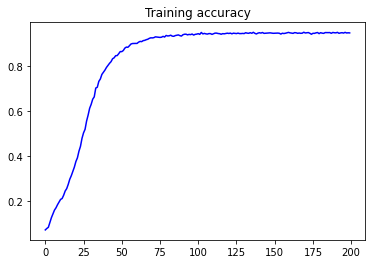

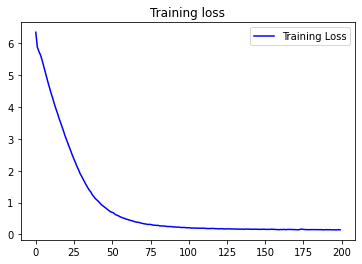

In [15]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

# Generating fake comments

To generate fake tweets, we use the below architecture:

![](imgs/text_gen.png)

The idea is to give one or more starting token(s) to our model, and generate the next tokens until we generate `.`.

At each step, we select the token with the highest probability as our next token and generate the next one similartly using `model.predict_classes()`. 

**Note:** The model takes as input the activation `a` from the previous state of the LSTM and the token chosen, forward propagate by one step, and get a new output activation `a`. The new activation `a` can then be used to generate the output, using the `dense` layer with `softmax` activation as before. 



**Task 2**: Implement `generate()`. 

***

In [16]:
#TASK 2
# Implement the generate() function

def generate(seed_text):
    ### START CODE HERE ### 
    tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
    sentence = seed_text
    a = ''
    while a != '.':
      
        corpus = sentence.lower().split("\n")

        tokenizer.fit_on_texts(corpus)
    
        input_sequences = []
        for l in corpus:
            token_list = tokenizer.texts_to_sequences([l])[0]
                #for i in range(1, len(token_list)):
                   # n_gram_sequence = token_list[:i+1]
                   # print(n_gram_sequence)
            input_sequences.append(token_list)
        
        input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len-1, padding='pre'))
        prediction = model.predict_classes(input_sequences, verbose=0)
        if prediction[0] != 0:
          w = reverse_word_map[prediction[0]]
        sentence += ' '+ w
        a = w
    return sentence
    ### END CODE HERE ### 


**Let's test it:**

In [35]:
print('\n')
print(generate("COVID19 virus"))
print('\n\n')
print(generate("COVID19 is the"))
print('\n\n')
print(generate("The usa is"))
print('\n\n')
print(generate("The new virus"))
print('\n\n')
print(generate("China has"))
print('\n\n')



COVID19 virus covid19 of virus covid19 because a kill covid19 test it for your on the the the government the military of the .



COVID19 is the outbreak senegal be 7 test for on on at the home the the the all like get getting of to in the , can so the and should so the all and is is .



The usa is outbreak senegal be 7 test for on on at the home the home the , coronavirus states covid19 of the , two are the , up can so the and should cvd that them door at down citizens up , .



The new virus outbreak senegal be 7 test for on on at the home the home the , coronavirus states covid19 of the , two are the , up can so the and should cvd that them door at down citizens up , .



China has covid19 outbreak senegal be 7 test for on on at the the the the on disease coronavirus kill the of and to have the are can , the and to in kills a that not door for it very have the coronavirus means city .





**Let's test it in an interactive mode:**

In [18]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: covid19 was
covid19 was covid19 of virus a be covid19 test a kill for . 

# Generating text by sampling

The previous part is generating text by choosing the token with the highest probability. Now, we sill generate text by sampling as shown in the architecture below:

![](imgs/text_gen_sample.png)


**TASK 3:** Implement the `generate_sample()` function. To sample a token from the output at each timestep, you need to use the following two functions:
- `model.predict_proba()`: To get probabilities from the output layer.
- `np.random.choice()`: To sample from the token list using the probaility array of each token.

***

In [20]:
#TASK 3
# Implement the generate_sample() function
def generate_sample(seed_text):
    
   ### START CODE HERE ### 
    tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
    sentence = seed_text
    a = ''
    count = 0
    while a != '.':
      
        corpus = sentence.lower().split("\n")

        tokenizer.fit_on_texts(corpus)
    
        input_sequences = []
        for l in corpus:
            token_list = tokenizer.texts_to_sequences([l])[0]
            input_sequences.append(token_list)
        
        input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len-1, padding='pre'))
        prediction = model.predict_proba(input_sequences, verbose=0)
        p = np.random.choice(prediction[0])
        p = np.where(prediction[0] == p)
        if p[0][0] != 0:
          w = reverse_word_map[p[0][0]]
        sentence += ' '+ w
        a = w
        count+=1
        if(count == 50):
          break

    return sentence
    ### END CODE HERE ### 

**Let's test it in an interactive mode:**

In [37]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
print('\n') 
for w in generate_sample(usr_input).split():   
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: kids cant


kids cant chronic tweeted food prophesied across go own medical against center that exposed clorox reduces february covid19 lotteries agendas your never whitmer risk lemon sunlight terrorism kill released economy see hell disease gunpoint use… banner weapon already spread bought knocks agreed you suggests whole mobile these governors vaping cattle italy chance 

# Generate your own text 

Below, use you own data to generate content for a different application:

In [33]:
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
data = open('Sherlock.txt').read().replace(".", " . ").replace(",", " , ").replace("?", " ? ").replace("!", " ! ")

corpus = data.lower().split(".")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

c=[]
for l in corpus:
    c.append(l + ' .')

print("Example of fake tweets: ",c[:2])
print("Size of the vocabulary = ", total_words)
index = [(k, v) for k, v in tokenizer.word_index.items()]
print("Example of our word index = ", index[0:10])

input_sequences = []
for line in c:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

input_to_model, label = input_sequences[:,:-1],input_sequences[:,-1]
print(label.shape)

label = ku.to_categorical(label)

Example of fake tweets:  ['to sherlock holmes she is always _the_ woman  .', '  i have seldom heard him\nmention her under any other name  .']
Size of the vocabulary =  324
Example of our word index =  [(',', 1), ('the', 2), ('and', 3), ('of', 4), ('his', 5), ('to', 6), ('was', 7), ('a', 8), ('in', 9), ('i', 10)]
(636,)


In [23]:
print(input_to_model.shape)
print(label.shape)
print(input_sequences.shape)

(636, 88)
(636, 324)
(636, 89)


In [24]:
size = 128
def deep_fake_comment_model1():
    ### START CODE HERE ### 
    model1 = Sequential()
    model1.add(Embedding(324, size, input_length=88))
    model1.add(LSTM(size))
    model1.add(Dropout(0.1))
    model1.add(Dense(324, activation='softmax'))
    model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model1
    ### END CODE HERE ### 
    
#Print details of the model.
model1 = deep_fake_comment_model1()

In [25]:
history = model1.fit(input_to_model, label, epochs=200, batch_size=32, verbose=1)

Epoch 1/200
20/20 [==============================] - 0s 11ms/step - loss: 5.6789 - accuracy: 0.0487
Epoch 2/200
20/20 [==============================] - 0s 9ms/step - loss: 5.2698 - accuracy: 0.0692
Epoch 3/200
20/20 [==============================] - 0s 9ms/step - loss: 5.1677 - accuracy: 0.0519
Epoch 4/200
20/20 [==============================] - 0s 8ms/step - loss: 5.1255 - accuracy: 0.0692
Epoch 5/200
20/20 [==============================] - 0s 8ms/step - loss: 5.1049 - accuracy: 0.0676
Epoch 6/200
20/20 [==============================] - 0s 8ms/step - loss: 5.0675 - accuracy: 0.0708
Epoch 7/200
20/20 [==============================] - 0s 8ms/step - loss: 5.0303 - accuracy: 0.0802
Epoch 8/200
20/20 [==============================] - 0s 7ms/step - loss: 4.9644 - accuracy: 0.0723
Epoch 9/200
20/20 [==============================] - 0s 9ms/step - loss: 4.8665 - accuracy: 0.0912
Epoch 10/200
20/20 [==============================] - 0s 8ms/step - loss: 4.7560 - accuracy: 0.1179
Epoch 11

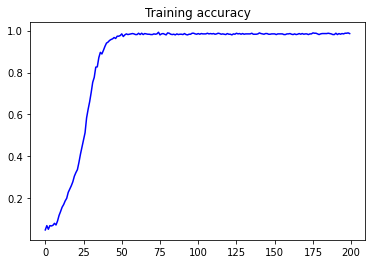

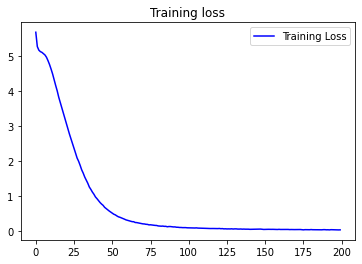

In [26]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [29]:
def generate_sample1(seed_text):
    ### START CODE HERE ### 
    tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
    sentence = seed_text
    a = ''
    while a != '.':
      
        corpus = sentence.lower().split("\n")

        tokenizer.fit_on_texts(corpus)
    
        input_sequences = []
        for l in corpus:
            token_list = tokenizer.texts_to_sequences([l])[0]
            input_sequences.append(token_list)
        input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len-1, padding='pre'))
        prediction = model1.predict_classes(input_sequences, verbose=0)
        if prediction[0] != 0:
          w = reverse_word_map[prediction[0]]
        sentence += ' ' + w
        a = w
    return sentence
    ### END CODE HERE ### 

In [38]:
"""
Use - 'My marriage had drifted'))
"""
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
print('\n')
for w in generate_sample1(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)

Write the beginning of your tweet, the algorithm machine will complete it. Your input is: My marriage had drifted


My marriage had drifted the flu has flu have her invented years that can it home that reports italy spread it it , , , it the days it days from viruses folks the the the the the the folks which out lot should should a . 

# Congratulations!

You've come to the end of this assignment, and have seen how to build a deep learning architecture that generate fake tweets/comments. 

Congratulations on finishing this notebook! 

